<a href="https://colab.research.google.com/github/RoyZhaoGA/DroughtForecastAI/blob/main/Spatial_temporal_graph_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install lightning torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 36.3 MB/s eta 0:00:00


In [2]:
!pip install torch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
CHECKPOINT_PATH

'saved_models/GNNs/'

In [4]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/DroughtCastAI/Dataset/GNNs"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Import Graph

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pickle
Graph = pickle.load(open('/content/drive/MyDrive/DroughtCastAI/Dataset/Spatial_temporal_grpah.pickle', 'rb'))

In [3]:
Graph

In [ ]:
len(Graph.nodes)

83580

In [8]:
Graph.nodes[36986]

{'row_index': 36986,
 'Month': 202211,
 'Lat': -33.238,
 'Lon': 18.865,
 'temperature_2m': 292.636,
 'temperature_2m_min': 283.228,
 'temperature_2m_max': 308.313,
 'dewpoint_temperature_2m': 282.864,
 'total_precipitation_sum': 0.0166007,
 'total_precipitation_min': 0.0,
 'total_precipitation_max': 0.00481202,
 'u_component_of_wind_10m': 1.00666,
 'v_component_of_wind_10m': 1.20606,
 'surface_net_solar_radiation_sum': 681535000.0,
 'total_evaporation_sum': -0.0276847,
 'soil_moisture_am': 0.112796,
 'soil_moisture_pm': 0.110107,
 'NDVI': 3640.99,
 'EVI': 2116.21,
 'next_month_tempreature': 293.258,
 'next_month_precipitation': 3.743e-06,
 'year': 2022,
 'month2': 11,
 'spei01': -0.960185}

In [4]:
len(Graph.nodes[36986])

24

In [9]:
import networkx as nx

monthslist = [202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308]

subset_graph = nx.Graph()
for node, data in Graph.nodes(data=True):
    if data.get('Month') in monthslist:
        subset_graph.add_node(node, **data)

for u, v in Graph.edges():
    if u in subset_graph.nodes() and v in subset_graph.nodes():
        subset_graph.add_edge(u, v)

len(subset_graph.nodes)
Graph = subset_graph

In [10]:
subset_graph.nodes[24697]

{'row_index': 24697,
 'Month': 202308,
 'Lat': 36.831,
 'Lon': 9.881,
 'temperature_2m': 300.416,
 'temperature_2m_min': 290.927,
 'temperature_2m_max': 316.689,
 'dewpoint_temperature_2m': 289.995,
 'total_precipitation_sum': 0.00421884,
 'total_precipitation_min': 0.0,
 'total_precipitation_max': 0.00182504,
 'u_component_of_wind_10m': 0.486217,
 'v_component_of_wind_10m': -0.879292,
 'surface_net_solar_radiation_sum': 595211000.0,
 'total_evaporation_sum': -0.0155104,
 'soil_moisture_am': 0.072868,
 'soil_moisture_pm': 0.0555854,
 'NDVI': 2068.83,
 'EVI': 1417.39,
 'next_month_tempreature': 299.922,
 'next_month_precipitation': 1.54105e-05,
 'year': 2023,
 'month2': 8,
 'spei01': -1.05509}

In [ ]:
subset_graph.edges()

EdgeView([(36986, 37086), (36986, 40586), (36986, 40686), (36986, 36987), (36986, 36988), (40586, 37086), (40586, 44286), (40586, 44386), (40586, 40686), (40586, 40587), (40586, 40588), (44286, 48186), (44286, 44386), (44286, 48086), (44286, 40686), (44286, 44287), (44286, 44288), (48086, 48186), (48086, 44386), (48086, 51886), (48086, 51786), (48086, 48087), (48086, 48088), (51786, 48186), (51786, 55586), (51786, 55486), (51786, 51886), (51786, 51787), (51786, 51788), (55486, 55586), (55486, 59186), (55486, 51886), (55486, 55487), (55486, 55488), (37086, 37186), (37086, 33486), (37086, 40686), (37086, 40786), (37086, 37087), (37086, 37088), (40686, 37186), (40686, 44386), (40686, 40786), (40686, 44486), (40686, 40687), (40686, 40688), (44386, 48186), (44386, 40786), (44386, 48286), (44386, 44486), (44386, 44387), (44386, 44388), (48186, 48286), (48186, 44486), (48186, 51886), (48186, 51986), (48186, 48187), (48186, 48188), (51886, 48286), (51886, 55586), (51886, 51986), (51886, 55686)

In [ ]:
subset_graph.nodes

NodeView((36986, 40586, 44286, 48086, 51786, 55486, 37086, 40686, 44386, 48186, 51886, 55586, 59186, 33486, 37186, 40786, 44486, 48286, 51986, 55686, 59286, 62786, 30086, 33586, 37286, 40886, 44586, 48386, 52086, 55786, 59386, 62886, 30186, 33686, 37386, 40986, 44686, 48486, 52186, 55886, 59486, 62986, 66285, 30286, 33786, 37486, 41086, 44786, 48586, 52286, 55986, 59586, 63086, 66385, 69585, 79471, 80571, 81571, 30386, 33886, 37586, 41186, 44886, 48686, 52386, 56086, 59686, 63186, 66485, 69685, 79571, 80671, 81671, 27087, 30486, 33986, 37686, 41286, 44986, 48786, 52486, 56186, 59786, 63286, 66585, 69784, 79671, 80771, 81771, 27187, 30586, 34086, 37786, 41386, 45086, 48886, 52586, 56286, 59886, 63386, 66685, 69883, 72683, 79771, 80871, 81871, 82670, 24788, 27287, 30686, 34186, 37886, 41486, 45186, 48986, 52686, 56386, 59986, 63486, 66785, 69983, 72783, 75079, 79871, 80971, 81971, 82770, 27387, 30786, 34286, 37986, 41586, 45286, 49086, 52786, 56486, 60086, 63586, 66885, 70083, 72883, 751

In [6]:
len(subset_graph.edges)

45292

**Convert Graph into pytorch geometric dataset**

In [11]:
#EDGE INDEX FOR FULL DATASET
# # Extract edge list
# edge_list = list(Graph.edges())

# # Convert edge list to a 2D tensor
# edge_index = torch.tensor(edge_list, dtype=torch.long)
# edge_index = edge_index.t().contiguous()

# # Ensure the tensor shape is [2, num_edges]
# edge_index = edge_index.view(2, -1)

#EDGE INDEX FOR SMALL DATASET
# Extract edge list
original_edge_list = list(Graph.edges())
edge_list = []

for i, node in enumerate(Graph.nodes()):
  for j, node2 in enumerate(Graph.nodes()):
    if (node, node2) in Graph.edges():
      edge_list.append((i,j))

# Convert edge list to a 2D tensor
edge_index = torch.tensor(edge_list, dtype=torch.long)
edge_index = edge_index.t().contiguous()

# Ensure the tensor shape is [2, num_edges]
edge_index = edge_index.view(2, -1)

spei01_features = [Graph.nodes[node]['spei01'] for node in Graph.nodes()]

# Convert to a tensor
y = torch.tensor(spei01_features, dtype=torch.float)

feature_names = ['Month', 'Lat', 'Lon', 'temperature_2m', 'temperature_2m_min',
                 'temperature_2m_max', 'dewpoint_temperature_2m', 'total_precipitation_sum',
                 'total_precipitation_min', 'total_precipitation_max', 'u_component_of_wind_10m',
                 'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
                 'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
                 'next_month_precipitation', 'year', 'month2']

# Extract the features for each node
node_features = []
for node in Graph.nodes():
    node_feature_values = [Graph.nodes[node].get(feature, 0) for feature in feature_names]  # Defaulting missing values to 0
    node_features.append(node_feature_values)

# Convert to a PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

train_months = [202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306]
val_months = [202307]
test_months = [202308]

train_mask_list = []

for node in Graph.nodes():
    is_in_train_months = Graph.nodes[node]['Month'] in train_months
    train_mask_list.append(is_in_train_months)

train_mask = torch.tensor(train_mask_list, dtype=torch.bool)

val_mask_list = []

for node in Graph.nodes():
    is_in_val_months = Graph.nodes[node]['Month'] in val_months

    val_mask_list.append(is_in_val_months)

val_mask = torch.tensor(val_mask_list, dtype=torch.bool)

test_mask_list = []

for node in Graph.nodes():
    is_in_test_months = Graph.nodes[node]['Month'] in test_months

    test_mask_list.append(is_in_test_months)

test_mask = torch.tensor(test_mask_list, dtype=torch.bool)

graph_data = torch_geometric.data.Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

In [12]:
edge_index

tensor([[   0,    0,    0,  ..., 8359, 8359, 8359],
        [   1,    6,    7,  ..., 8353, 8354, 8358]])

In [ ]:
y

tensor([-0.9602, -1.0016, -2.1655,  ..., -2.6574, -1.4963, -1.0551])

In [ ]:
x

tensor([[ 2.0221e+05, -3.3238e+01,  1.8865e+01,  ...,  3.7430e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.0661e+01,  ...,  6.4444e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.2458e+01,  ...,  1.2640e-05,
          2.0220e+03,  1.1000e+01],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]])

In [ ]:
train_months = [201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704,
201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712,
201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,
201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008,
202009, 202010, 202011, 202012, 202101, 202102]
val_months = [202103, 202104, 202105, 202106, 202107, 202108, 202109,
202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205]
test_months = [202206, 202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308]

In [ ]:
len(train_months)

8

In [ ]:
len(val_months)

1

In [ ]:
len(test_months)

1

In [ ]:
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [ ]:
torch.sum(train_mask).item()

6688

In [ ]:
val_mask

tensor([False, False, False,  ..., False, False, False])

In [ ]:
torch.sum(val_mask).item()

836

In [ ]:
test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [ ]:
torch.sum(test_mask).item()

836

In [ ]:
graph_data

Data(x=[8360, 22], edge_index=[2, 45292], y=[8360], train_mask=[8360], val_mask=[8360], test_mask=[8360])

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
class GraphDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.num_node_features = data.x.size(1)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return graph_data

In [15]:
graph_dataset = GraphDataset(graph_data)

In [ ]:
graph_dataset.data

Data(x=[8360, 22], edge_index=[2, 90584], y=[8360], train_mask=[8360], val_mask=[8360], test_mask=[8360])

In [ ]:
graph_dataset.__len__()

1

In [13]:
graph_dataset.__getitem__(0)

Data(x=[8360, 22], edge_index=[2, 90584], y=[8360], train_mask=[8360], val_mask=[8360], test_mask=[8360])

In [16]:
graph_dataset.num_node_features

22

## Graph Neural Networks

In [17]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [45]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        print("Model Initialized")

        print("self:")
        print(self)

        print("c_in:")
        print(c_in)

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            print("layer", l_idx);
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.Tanh(),
                #nn.LeakyReLU(inplace=True)
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        i=0
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            print("layer", i);
            i+=1
            print(layer)
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
            print("----x:")
            print(x)
            print(x.size())
        return x

In [19]:
class NodeLevelGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, "Unknown forward mode: %s" % mode

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log("test_acc", acc)

In [ ]:
graph_data.y

tensor([-0.9602, -1.0016, -2.1655,  ..., -2.6574, -1.4963, -1.0551])

In [ ]:
mask = graph_data.train_mask

In [ ]:
x, edge_index = graph_data.x, graph_data.edge_index

In [ ]:
x[mask].size()

torch.Size([6688, 22])

In [ ]:
x.size()

torch.Size([8360, 22])

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)

In [ ]:
graph_data.x

tensor([[ 2.0221e+05, -3.3238e+01,  1.8865e+01,  ...,  3.7430e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.0661e+01,  ...,  6.4444e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.2458e+01,  ...,  1.2640e-05,
          2.0220e+03,  1.1000e+01],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]])

In [ ]:
graph_data.edge_index

tensor([[36986, 36986, 36986,  ..., 18598, 20498, 22398],
        [37086, 40586, 40686,  ..., 20498, 22398, 24697]])

In [ ]:
model.model(graph_data.x, graph_data.edge_index)

tensor([[1.3082e+08],
        [1.7518e+08],
        [1.6212e+08],
        ...,
        [1.4125e+08],
        [1.5298e+08],
        [1.3369e+08]], grad_fn=<AddBackward0>)

In [33]:
loss_list = []

In [26]:
class NodeLevelRegressionGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        # Initialize the model
        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)  # Ensure MLPModel outputs continuous values
        else:
            self.model = GNNModel(**model_kwargs)  # Ensure GNNModel outputs continuous values

        # Use Mean Squared Error Loss for regression
        self.loss_module = nn.MSELoss()

    def forward(self, data, mode="train"):
        # print("Data:")
        # print(data)
        # print("edge index:")
        # print(data.edge_index)
        x, edge_index = data.x, data.edge_index

        print("Before model x:")
        print(x)
        print("edge_index:")
        print(edge_index)
        x = self.model(x, edge_index)
        print("x:")
        print(x)
        print("y:")
        print(data.y)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            raise ValueError(f"Unknown forward mode: {mode}")

        loss = self.loss_module(x[mask], data.y[mask])
        #loss = self.loss_module(x.squeeze(), data.y.squeeze())
        print("Loss: ")
        print(loss)
        loss_list.append(loss)
        return loss

    def configure_optimizers(self):
        # Optimizer can be adjusted as needed
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):

        loss = self.forward(batch, mode="train")
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="val")
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="test")
        self.log("test_loss", loss)

In [21]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=False,
    )  # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result

In [ ]:
graph_data

Data(x=[8360, 22], edge_index=[2, 90584], y=[8360], train_mask=[8360], val_mask=[8360], test_mask=[8360])

In [ ]:
node_data_loader = geom_data.DataLoader(graph_data, batch_size=1)

In [ ]:
node_data_loader

In [32]:
def train_node_regressor(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevelRegression" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=2,
        enable_progress_bar=True
    )

    pretrained_filename = "bruh"
    #os.path.join(CHECKPOINT_PATH, "NodeLevelRegression%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelRegressionGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        # Ensure the model's output layer and loss are suitable for regression
        model = NodeLevelRegressionGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=1, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelRegressionGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test the best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    train_loss = model.forward(batch, mode="train")
    val_loss = model.forward(batch, mode="val")
    result = {"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_result[0]["test_loss"]}
    return model, result

In [23]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train_loss" in result_dict:
        print("Train loss: " + str(result_dict["train_loss"]))
    if "val_loss" in result_dict:
        print("Val loss: " + str(result_dict["val_loss"]))
    print("Test loss: " + str(result_dict["test_loss"]))

In [37]:
x

tensor([[ 2.0221e+05, -3.3238e+01,  1.8865e+01,  ...,  3.7430e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.0661e+01,  ...,  6.4444e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.2458e+01,  ...,  1.2640e-05,
          2.0220e+03,  1.1000e+01],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]])

In [ ]:
model = NodeLevelGNN(
            model_name="GNN", c_in=graph_dataset.num_node_features, c_out=1, c_hidden=16, num_layers=2, dp_rate=0.1
        )

Model Initialized
self:
GNNModel()
c_in:
22


In [ ]:
node_gnn_result['train_loss']

tensor(inf, grad_fn=<MseLossBackward0>)

In [ ]:
print_results(node_gnn_result)

Train loss: tensor(inf, grad_fn=<MseLossBackward0>)
Val loss: tensor(inf, grad_fn=<MseLossBackward0>)
Test loss: inf


In [102]:
graph_dataset.data

Data(x=[8360, 22], edge_index=[2, 90584], y=[8360], train_mask=[8360], val_mask=[8360], test_mask=[8360])

In [53]:
node_gnn_model, node_gnn_result = train_node_regressor(
    model_name="GNN", layer_name="GCN", dataset=graph_dataset, c_hidden=16, num_layers=2, dp_rate=0.1
)

print_results(node_gnn_result)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Model Initialized
self:
GNNModel()
c_in:
22
layer 0


RuntimeError: ignored

In [51]:


from numba import cuda
device = cuda.get_current_device()
device.reset()

In [52]:
globallayer

tensor([])

In [49]:
loss_list = []

In [41]:
loss_list

[tensor(14.6779, device='cuda:0'),
 tensor(10.1458, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(39.1025, device='cuda:0'),
 tensor(49.0030, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(73.6259, device='cuda:0'),
 tensor(40.7601, device='cuda:0'),
 tensor(48.9447, grad_fn=<MseLossBackward0>),
 tensor(38.9240, grad_fn=<MseLossBackward0>),
 tensor(14.6779, device='cuda:0'),
 tensor(10.1458, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(39.1025, device='cuda:0'),
 tensor(49.0030, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(73.6259, device='cuda:0'),
 tensor(40.7601, device='cuda:0'),
 tensor(48.9447, grad_fn=<MseLossBackward0>),
 tensor(38.9240, grad_fn=<MseLossBackward0>)]

In [29]:
import matplotlib.pyplot as plt
import torch

def plot_loss_graph(loss_data):
    """
    Plots the training loss over epochs.

    :param loss_data: List of loss values (as PyTorch tensors).
    """
    # Convert tensor list to a list of Python floats
    loss_values = [l.item() for l in loss_data]

    # Epochs (assuming each loss value corresponds to an epoch)
    epochs = range(1, len(loss_values) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_values, marker='o', color='b', label='Training Loss')

    # Adding titles and labels
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()


In [31]:
len(loss_list)

164

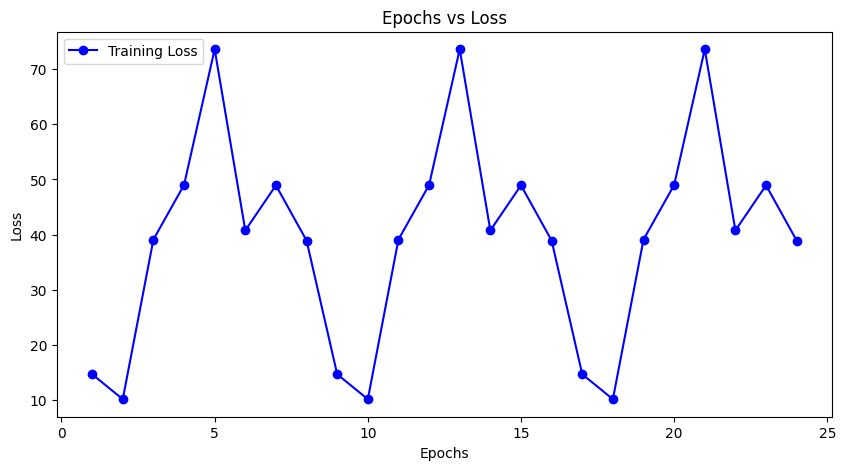

In [48]:
plot_loss_graph(loss_list)

In [ ]:
import torch
print(torch.cuda.is_available())

True


Although the MLP can overfit on the training dataset because of the high-dimensional input features,
it does not perform too well on the test set.
Let's see if we can beat this score with our graph networks:

In [ ]:
node_gnn_model, node_gnn_result = train_node_classifier(
    model_name="GNN", layer_name="GCN", dataset=graph_data, c_hidden=16, num_layers=2, dp_rate=0.1
)
print_results(node_gnn_result)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


RuntimeError: ignored